
# Importing required libraries

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading the dataset

In [2]:
# Load the HDF5 dataset
with h5py.File(r"C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\Data Sets\jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5"
, 'r') as f:
    images = np.array(f['image'])  # Shape: (N, 25, 25)
    labels = np.array(f['signal'])  # Shape: (N,)

# Verify dataset
print(f"Total images: {len(images)}")
print(f"Signal ratio: {labels.mean():.2%}")


Total images: 872666
Signal ratio: 50.00%


# Data Preprocessing

In [3]:

# Normalize and reshape
images = (images - images.min()) / (images.max() - images.min())  # [0,1] range
images = np.expand_dims(images, axis=-1)  # Add channel dimension (25,25,1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Model Building

In [4]:
def build_model(input_shape=(25,25,1)):
    model = models.Sequential([
        # Convolutional Base
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        # Classifier Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    # Initialize output bias for class balance
    output_bias = tf.keras.initializers.Constant(np.log([y_train.mean()/(1-y_train.mean())]))
    model.layers[-1].bias.assign([output_bias(1)[0]])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 64)         256       
 hNormalization)                                                 
                                                        

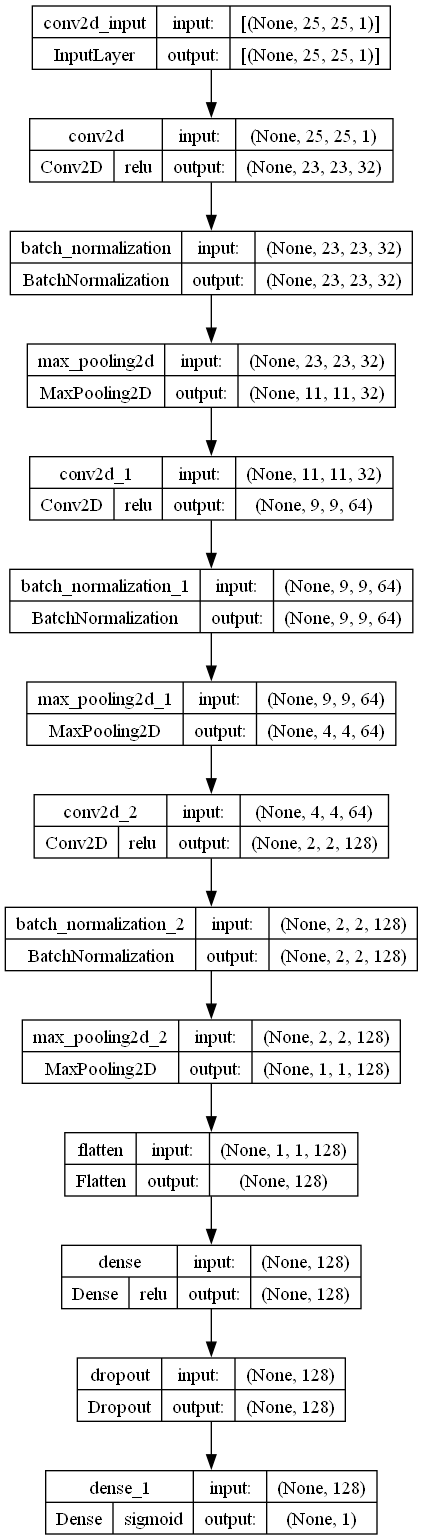

In [9]:
tf.keras.utils.plot_model(model,
                          show_layer_activations=True,
                          show_shapes=True)

# ImageData Generator with Data Augmentation

In [ ]:
# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',  # Important for jet images
    cval=0                # Fill with zeros (background)
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

# Calculate class weights properly
class_counts = np.bincount(y_train.astype(int))
total_samples = len(y_train)
class_weight = {
    0: total_samples / (2 * class_counts[0]),  # Background weight
    1: total_samples / (2 * class_counts[1])   # Signal weight
}

print(f"Class weights: {class_weight}")  # Should show something like {0: 0.8, 1: 1.2}

Class weights: {0: 1.0, 1: 1.0}
Epoch 1/10
21816/21816 [==============================] - 222s 10ms/step - loss: 0.4854 - accuracy: 0.7719 - auc: 0.8484 - val_loss: 1.6442 - val_accuracy: 0.5160 - val_auc: 0.8296
Epoch 2/10
21816/21816 [==============================] - 207s 9ms/step - loss: 0.4567 - accuracy: 0.7900 - auc: 0.8675 - val_loss: 0.5060 - val_accuracy: 0.7657 - val_auc: 0.8561
Epoch 3/10
21816/21816 [==============================] - 207s 9ms/step - loss: 0.4484 - accuracy: 0.7947 - auc: 0.8727 - val_loss: 1.0046 - val_accuracy: 0.5884 - val_auc: 0.8598
Epoch 4/10
21816/21816 [==============================] - 207s 9ms/step - loss: 0.4447 - accuracy: 0.7967 - auc: 0.8749 - val_loss: 0.4470 - val_accuracy: 0.7914 - val_auc: 0.8754
Epoch 5/10
21816/21816 [==============================] - 208s 10ms/step - loss: 0.4422 - accuracy: 0.7984 - auc: 0.8765 - val_loss: 0.4663 - val_accuracy: 0.7866 - val_auc: 0.8802
Epoch 6/10
21816/21816 [==============================] - 207s 9ms

# Fitting the model

In [ ]:
# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,  # Important for generator
    validation_data=val_datagen.flow(X_val, y_val),
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weight,
    verbose=1
)

# Evaluation

In [ ]:
# Evaluate
results = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {results[1]:.2%}")
print(f"Validation AUC: {results[2]:.2%}")

# Prediction function
def predict_jet_image(image_path, model):
    """Predict from PNG file"""
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale',
        target_size=(25,25)
    )
    arr = tf.keras.preprocessing.image.img_to_array(img)/255.0
    arr = np.expand_dims(arr, axis=0)
    prob = model.predict(arr)[0][0]
    return 'signal' if prob > 0.5 else 'background', prob


5455/5455 [==============================] - 36s 7ms/step - loss: 0.5557 - accuracy: 0.7029 - auc: 0.8697
Validation Accuracy: 70.29%
Validation AUC: 86.97%
1/1 [==============================] - 0s 344ms/step
Prediction: signal (100.00%)


# Testing on a single sample of image

In [ ]:
# Test on sample images
sample_path = r"test_images_jetimages\signal_10.png"
pred_class, pred_prob = predict_jet_image(sample_path, model)
print(f"Prediction: {pred_class} ({pred_prob:.2%})")

# Generating Accuracy-Loss curve

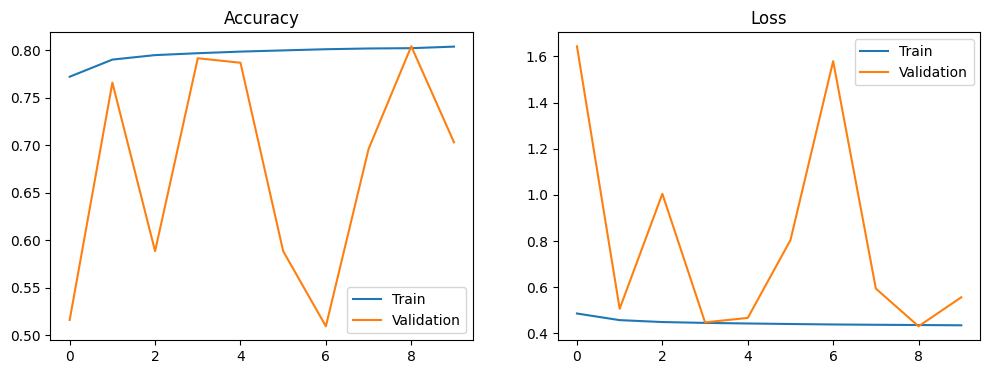

In [17]:
import matplotlib.pyplot as plt

def plot_results(history):
    plt.figure(figsize=(12,4))
    
    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

plot_results(history)

# Visualizing the Predictions

1/1 [==============================] - 0s 21ms/step


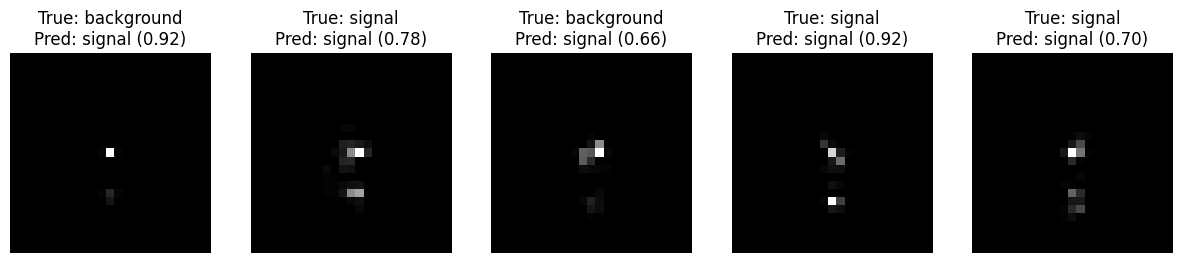

In [ ]:
def visualize_predictions(X, y, model, num_samples=5):
    plt.figure(figsize=(15,3))
    indices = np.random.choice(range(len(X)), num_samples)
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = 'signal' if y[idx] else 'background'
        pred_prob = model.predict(np.expand_dims(img, axis=0))[0][0]
        pred_label = 'signal' if pred_prob > 0.5 else 'background'
        
        plt.subplot(1,num_samples,i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})")
        plt.axis('off')
    plt.show()

visualize_predictions(X_val, y_val, model)

# Saving the model

In [25]:
model.save("final_cnn_model.h5")

# Saving the test samples

In [24]:
import os
import numpy as np
from PIL import Image
import random

# Create output directory
sample_dir = "huggingface_samples"
os.makedirs(sample_dir, exist_ok=True)

# Get indices of signal and background samples
signal_indices = np.where(y_val == 1)[0]
background_indices = np.where(y_val == 0)[0]

# Select 25 random samples from each class
selected_indices = (
    random.sample(list(signal_indices), 25) + 
    random.sample(list(background_indices), 25)
)

# Save the selected samples
for idx in selected_indices:
    # Convert normalized image back to 0-255 range
    img_array = (X_val[idx].squeeze() * 255).astype(np.uint8)
    img = Image.fromarray(img_array, mode='L')
    
    # Save with label in filename
    label = "signal" if y_val[idx] == 1 else "background"
    img.save(os.path.join(sample_dir, f"{label}_{idx}.png"))

print(f"✅ Saved 50 validation samples to {sample_dir}/")
print(f"- Signal samples: {len([x for x in os.listdir(sample_dir) if 'signal' in x])}")
print(f"- Background samples: {len([x for x in os.listdir(sample_dir) if 'background' in x])}")

# Verify first few samples
print("\nSample files created:")
for fname in os.listdir(sample_dir)[:5]:
    print(f"- {fname}")

✅ Saved 50 validation samples to huggingface_samples/
- Signal samples: 25
- Background samples: 25

Sample files created:
- background_107605.png
- background_108227.png
- background_112008.png
- background_120212.png
- background_129579.png
